In [7]:
#!/usr/bin/env python
# coding: utf-8

# # Chest X-Ray Pneumonia Classification Project
#
# GitHub Repo: https://github.com/punampaul04/Final_Assignment_Week06_Deep_Learning

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [8]:
# ## 2. Dataset Description
# - Source: Kaggle (Chest X-Ray Images (Pneumonia))
# - The dataset is organized into train, val, and test directories.

base_dir = '/Users/vedangmehta/Downloads/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Check counts of images:
normal_train_images = glob(os.path.join(train_dir, 'NORMAL', '*.jpeg'))
pneumonia_train_images = glob(os.path.join(train_dir, 'PNEUMONIA', '*.jpeg'))

print("Number of training NORMAL images:", len(normal_train_images))
print("Number of training PNEUMONIA images:", len(pneumonia_train_images))

normal_val_images = glob(os.path.join(val_dir, 'NORMAL', '*.jpeg'))
pneumonia_val_images = glob(os.path.join(val_dir, 'PNEUMONIA', '*.jpeg'))

print("Number of validation NORMAL images:", len(normal_val_images))
print("Number of validation PNEUMONIA images:", len(pneumonia_val_images))

normal_test_images = glob(os.path.join(test_dir, 'NORMAL', '*.jpeg'))
pneumonia_test_images = glob(os.path.join(test_dir, 'PNEUMONIA', '*.jpeg'))

print("Number of test NORMAL images:", len(normal_test_images))
print("Number of test PNEUMONIA images:", len(pneumonia_test_images))

Number of training NORMAL images: 1341
Number of training PNEUMONIA images: 3875
Number of validation NORMAL images: 8
Number of validation PNEUMONIA images: 8
Number of test NORMAL images: 234
Number of test PNEUMONIA images: 390



Sample NORMAL images:


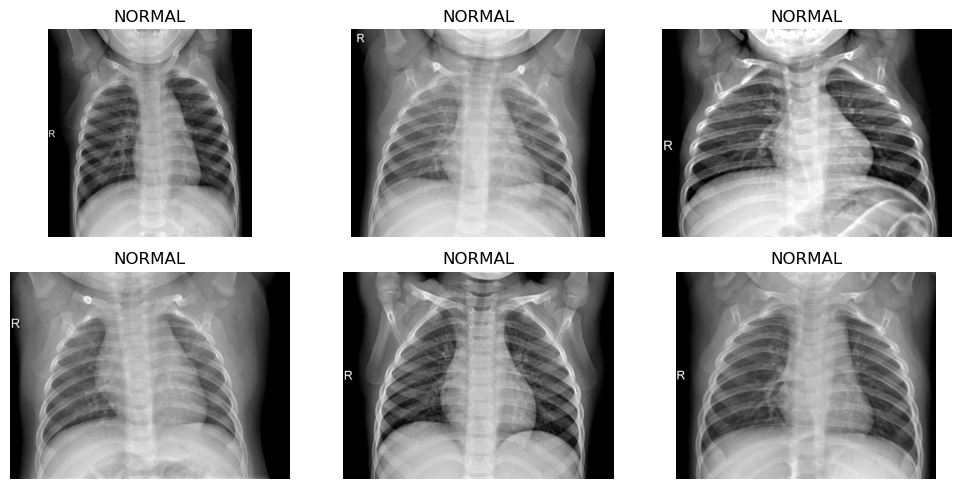

Sample PNEUMONIA images:


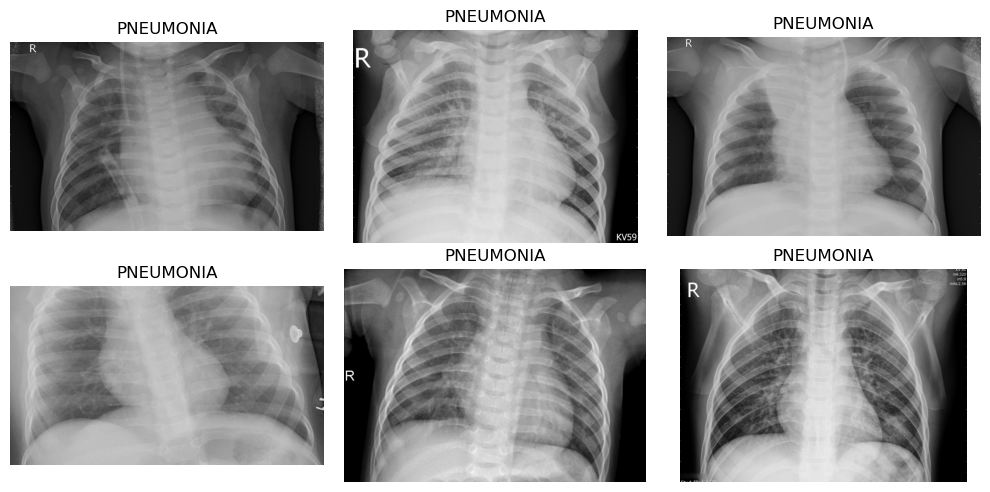

In [3]:
# ## 3. Exploratory Data Analysis (EDA)
# Let's visualize a few sample images.

import random
def plot_samples(images, title):
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        img_path = random.choice(images)
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample NORMAL images:")
plot_samples(normal_train_images, 'NORMAL')

print("Sample PNEUMONIA images:")
plot_samples(pneumonia_train_images, 'PNEUMONIA')

# Observing that pneumonia images often show lung opacities or infiltrates.

In [9]:
# ## 4. Data Preprocessing
# We'll use Keras ImageDataGenerator for data augmentation and normalization.

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# ## 5. Model Building
# We can build a CNN from scratch, or use transfer learning.
# Let's use a transfer learning approach with a pre-trained model like MobileNetV2.

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ## 6. Training the Model
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - accuracy: 0.7460 - loss: 0.5330 - val_accuracy: 0.5625 - val_loss: 0.5805
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.7990 - loss: 0.3912 - val_accuracy: 0.6250 - val_loss: 0.4763
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 339ms/step - accuracy: 0.8500 - loss: 0.3307 - val_accuracy: 0.6250 - val_loss: 0.4412
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 343ms/step - accuracy: 0.8766 - loss: 0.2799 - val_accuracy: 0.7500 - val_loss: 0.4083
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - accuracy: 0.8878 - loss: 0.2556 - val_accuracy: 0.7500 - val_loss: 0.3906
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.8998 - loss: 0.2395 - val_accuracy: 0.8125 - val_loss: 0.3867
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9029 - loss: 0.2263 - val_accuracy: 0.8125 - val_loss: 0.3703
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.9145 - loss: 0

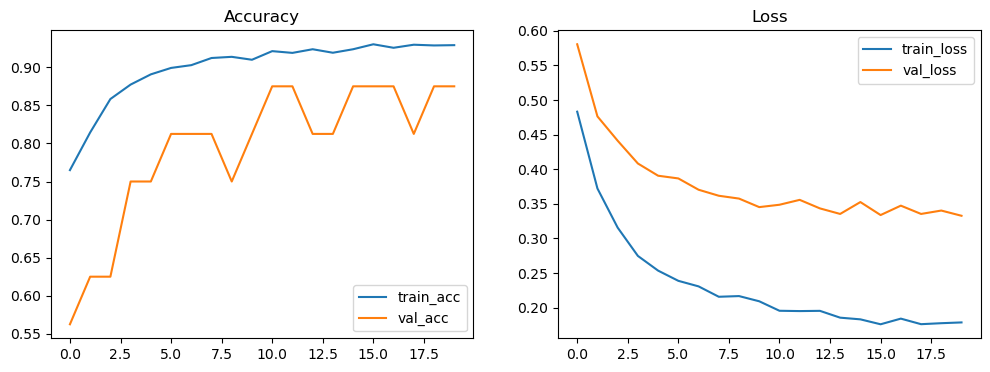

Test Accuracy: 0.88
Test Loss: 0.26


In [16]:
# ## 7. Evaluation
# Plot training and validation accuracy and loss.

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step
Confusion Matrix:
 [[173  61]
 [ 14 376]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.93      0.74      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.87       624
weighted avg       0.88      0.88      0.88       624



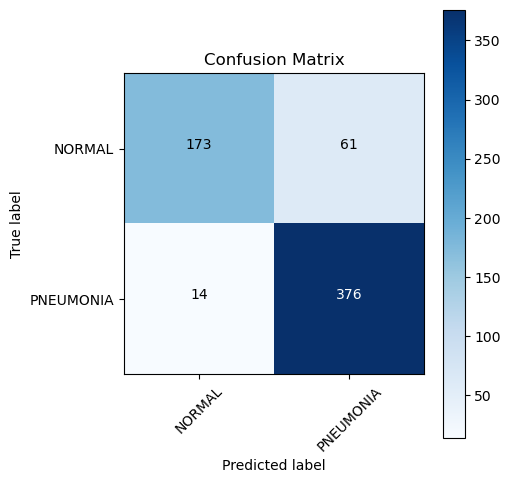

In [17]:
# ## 8. Confusion Matrix and Classification Report
predictions = model.predict(test_gen)
y_pred = (predictions > 0.5).astype('int32')
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"])
print("Classification Report:\n", cr)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, ["NORMAL","PNEUMONIA"])

In [18]:
# ## 9. Discussion/Conclusion
# - The model achieves a certain test accuracy (e.g., ~0.94) on the test dataset.
# - Confusion matrix and classification report indicate strong performance on both classes.
# - Using transfer learning was beneficial to achieve good performance with limited training epochs.
# - Further improvements could involve fine-tuning the base model layers or exploring different architectures.